In [1]:
%matplotlib inline
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
import collections

import cartopy
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, RIVERS
import seaborn as sns

In [2]:
domain = xr.open_dataset(os.path.join('/p/work1/gergel/lwe', 
                                      'domain.lnd.wr50a_ar9v4.100920.nc'))

__Load Low Warming Ensemble `TBOT` output (temperature at the bottom level of the atmosphere)__

In [3]:
tbot_dir = '/p/work1/gergel/lwe/TBOT'
tbot_hist_file = xr.open_mfdataset(os.path.join(tbot_dir, 'TBOT0*'),
                                  concat_dim='ensemble_member')
tbot_hist = tbot_hist_file['TBOT'].sel(time=slice('1976-09-01', '2005-08-31'))

tbot_1pt5_file = xr.open_mfdataset(os.path.join(tbot_dir, 'TBOT.1pt5degC.*'),
                                  concat_dim='ensemble_member')
tbot_1pt5 = tbot_1pt5_file['TBOT'].sel(time=slice('2070-09-01', '2099-08-31'))

tbot_2pt0_file = xr.open_mfdataset(os.path.join(tbot_dir, 'TBOT.2pt0degC.*'),
                                  concat_dim='ensemble_member')
tbot_2pt0 = tbot_2pt0_file['TBOT'].sel(time=slice('2070-09-01', '2099-08-31'))

__Let's look at a file:__

In [9]:
tbot_hist

<xarray.DataArray 'TBOT' (ensemble_member: 11, time: 348, nj: 205, ni: 275)>
dask.array<shape=(11, 348, 205, 275), dtype=float32, chunksize=(1, 348, 205, 275)>
Coordinates:
  * time     (time) datetime64[ns] 1976-09-01 1976-10-01 1976-11-01 ...
    xc       (nj, ni) float64 189.2 189.4 189.6 189.7 189.9 190.1 190.2 ...
    yc       (nj, ni) float64 16.53 16.78 17.02 17.27 17.51 17.76 18.0 18.25 ...
Dimensions without coordinates: ensemble_member, nj, ni
Attributes:
    long_name:     atmospheric air temperature
    units:         K
    cell_methods:  time: mean

__We're going to skip loading the full soil temperature ensemble members, it takes too long__

In [4]:
'''tsoi_dir = '/p/work1/gergel/lwe/TSOI'
tsoi_hist_file = xr.open_mfdataset(os.path.join(tsoi_dir, 'TSOI0*'),
                                  concat_dim='ensemble_member')
tsoi_hist = tsoi_hist_file['TSOI'].sel(time=slice('1976-09-01', '2005-08-31'))

tsoi_1pt5_file = xr.open_mfdataset(os.path.join(tsoi_dir, 'TSOI.1pt5degC.*'),
                                  concat_dim='ensemble_member')
tsoi_1pt5 = tsoi_1pt5_file['TSOI'].sel(time=slice('2070-09-01', '2099-08-31'))

tsoi_2pt0_file = xr.open_mfdataset(os.path.join(tsoi_dir, 'TSOI.2pt0degC.*'),
                                  concat_dim='ensemble_member')
tsoi_2pt0 = tsoi_2pt0_file['TSOI'].sel(time=slice('2070-09-01', '2099-08-31'))'''

"tsoi_dir = '/p/work1/gergel/lwe/TSOI'\ntsoi_hist_file = xr.open_mfdataset(os.path.join(tsoi_dir, 'TSOI0*'),\n                                  concat_dim='ensemble_member')\ntsoi_hist = tsoi_hist_file['TSOI'].sel(time=slice('1976-09-01', '2005-08-31'))\n\ntsoi_1pt5_file = xr.open_mfdataset(os.path.join(tsoi_dir, 'TSOI.1pt5degC.*'),\n                                  concat_dim='ensemble_member')\ntsoi_1pt5 = tsoi_1pt5_file['TSOI'].sel(time=slice('2070-09-01', '2099-08-31'))\n\ntsoi_2pt0_file = xr.open_mfdataset(os.path.join(tsoi_dir, 'TSOI.2pt0degC.*'),\n                                  concat_dim='ensemble_member')\ntsoi_2pt0 = tsoi_2pt0_file['TSOI'].sel(time=slice('2070-09-01', '2099-08-31'))"

__But let's look at just one ensemble member for the historical (1850-2005) period:__

In [6]:
tsoi_hist_ex = xr.open_dataset(os.path.join('/p/work1/gergel/lwe/TSOI', 
                                            'TSOI001_wr50a_ar9v4.nc'))

In [7]:
tsoi_hist_ex

<xarray.Dataset>
Dimensions:    (bnds: 2, levgrnd: 15, ni: 275, nj: 205, nv: 4, time: 1872)
Coordinates:
  * time       (time) datetime64[ns] 1850-02-01 1850-03-01 1850-04-01 ...
    xc         (nj, ni) float64 ...
    yc         (nj, ni) float64 ...
  * levgrnd    (levgrnd) float32 0.007100635 0.027925 0.062258575 ...
Dimensions without coordinates: bnds, ni, nj, nv
Data variables:
    time_bnds  (time, bnds) float64 ...
    xc_bnds    (nj, ni, nv) float64 ...
    yc_bnds    (nj, ni, nv) float64 ...
    BSW        (levgrnd, nj, ni) float32 ...
    DZSOI      (levgrnd, nj, ni) float32 ...
    HKSAT      (levgrnd, nj, ni) float32 ...
    SUCSAT     (levgrnd, nj, ni) float32 ...
    TSOI       (time, levgrnd, nj, ni) float32 ...
    WATSAT     (levgrnd, nj, ni) float32 ...
    ZSOI       (levgrnd, nj, ni) float32 ...
    area       (nj, ni) float32 ...
    landfrac   (nj, ni) float32 ...
    landmask   (nj, ni) float64 ...
    mcdate     (time) int32 ...
    mcsec      (time) int32 ...
 

__Define a `cartopy` RASM projection for our pan-Arctic domain figures:__

In [14]:
scale = '50m'

plt.rcParams.update({'mathtext.default':  'regular' })

class Rasm(ccrs.Projection):

    def __init__(self):

        proj4_params = {'R': 6371200.0,
                        'lat_0': 90.0,
                        'lat_1': 90,
                        'lat_2': 90,
                        'lon_0': -114.0+360,
                        'proj': 'lcc',
                        'units': 'm',
                        'x_0': 9469302.950316086,
                        'y_0': 6201952.603370549}

        super(Rasm, self).__init__(proj4_params)

    @property
    def boundary(self):
        coords = ((self.x_limits[0], self.y_limits[0]),(self.x_limits[1], self.y_limits[0]),
                  (self.x_limits[1], self.y_limits[1]),(self.x_limits[0], self.y_limits[1]),
                  (self.x_limits[0], self.y_limits[0]))

        return ccrs.sgeom.Polygon(coords).exterior

    @property
    def threshold(self):
        return 100000.0

    @property
    def x_limits(self):
        return (0, 16423961.103252266)

    @property
    def y_limits(self):
        return (0, 12228062.194885937)

__Define some plotting specs__

In [15]:
# plot_direc = '/u/home/gergel/plots/lwe'
dpi = 50

__Skipping these next sections because they are for post-processing our soil temperatures:__

In [16]:
# Convert soil temperatures to Celsius
K_to_C=273.15
tsoi_hist_C = tsoi_hist - K_to_C
tsoi_1pt5_C = tsoi_1pt5 - K_to_C
tsoi_2pt0_C = tsoi_2pt0 - K_to_C

depth_levs = tsoi_1pt5['levgrnd'] # meters

# take mean over years
tsoi_hist_C_months = tsoi_hist_C.groupby('time.month').mean('time')
tsoi_1pt5_C_months = tsoi_1pt5_C.groupby('time.month').mean('time')
tsoi_2pt0_C_months = tsoi_2pt0_C.groupby('time.month').mean('time')

# Extract August climatological mean soil temperatures
tsoi_hist_C_august = tsoi_hist_C_months.isel(month=7)
tsoi_1pt5_C_august = tsoi_1pt5_C_months.isel(month=7)
tsoi_2pt0_C_august = tsoi_2pt0_C_months.isel(month=7)

"K_to_C=273.15\ntsoi_hist_C = tsoi_hist - K_to_C\ntsoi_1pt5_C = tsoi_1pt5 - K_to_C\ntsoi_2pt0_C = tsoi_2pt0 - K_to_C\n\ndepth_levs = tsoi_1pt5['levgrnd'] # meters"

__Define some active layer thickness functions__

In [19]:
def check_freezing(list1, val): 
    return(all(x > val for x in list1)) 

def calculate_alt(soil_temps): 
    ''' 
    this function calculates active layer thickness 
    takes in soil temperatures and depths
    returns active layer depth (ALT)
    '''
    depths = tsoi_1pt5.levgrnd.values
    depths_reversed = depths[::-1]
    soil_temps_reversed = soil_temps[::-1]
    
    if check_freezing(soil_temps, 0.0):
        # entire column is above freezing
        alt = 0
    else:
        # start at the bottom of the soil column
        for i, soil_temp in enumerate(soil_temps_reversed):
            # find depth where temperature is above freezing
            if soil_temp >= 0.0:
                depth_a = depths_reversed[i] # depth above
                temp_a = soil_temp # temp above
                depth_b = depths_reversed[i-1] # depth below
                temp_b = soil_temps_reversed[i-1]
                # linearly interpolate to get depth where freezing occurs
                slope = (depth_b - depth_a) / (temp_b - temp_a)
                alt = (slope*(0.0 - temp_a)) + depth_a
                break
            else:
                # entire column is below freezing, no active layer
                alt = 0
    return(alt)

take ensemble mean to speed up ALT calculations 

In [20]:
'''tsoi_hist_august_mean = tsoi_hist_C_august.mean('ensemble_member')
tsoi_1pt5_august_mean = tsoi_1pt5_C_august.mean('ensemble_member')
tsoi_2pt0_august_mean = tsoi_2pt0_C_august.mean('ensemble_member')

tsoi_hist_C_august = tsoi_hist_C_august.persist()
tsoi_hist_C_august = tsoi_hist_C_august.load()
alt_hist = xr.apply_ufunc(calculate_alt,
                      tsoi_hist_C_august,
                      #dask='allowed',
                      input_core_dims=[['levgrnd']],
                      vectorize=True, 
                      )

tsoi_1pt5_C_august = tsoi_1pt5_C_august.persist()
tsoi_1pt5_C_august = tsoi_1pt5_C_august.load()
alt_1pt5 = xr.apply_ufunc(calculate_alt,
                      tsoi_1pt5_C_august,
                      # dask='parallelized',
                      input_core_dims=[['levgrnd']],
                      vectorize=True, 
                      output_dtypes=['float'])

tsoi_2pt0_C_august = tsoi_2pt0_C_august.persist()
tsoi_2pt0_C_august = tsoi_2pt0_C_august.load()
alt_2pt0 = xr.apply_ufunc(calculate_alt,
                      tsoi_2pt0_C_august,
                      # dask='parallelized',
                      input_core_dims=[['levgrnd']],
                      vectorize=True, 
                      output_dtypes=['float'])
alt_hist.to_netcdf(os.path.join('/p/cwfs/gergel/low_warming_ensemble/computed', 
                                'alt_hist.nc'))
alt_1pt5.to_netcdf(os.path.join('/p/cwfs/gergel/low_warming_ensemble/computed', 
                                'alt_1pt5.nc'))
alt_2pt0.to_netcdf(os.path.join('/p/cwfs/gergel/low_warming_ensemble/computed', 
                                'alt_2pt0.nc'))'''

"tsoi_hist_august_mean = tsoi_hist_C_august.mean('ensemble_member')\ntsoi_1pt5_august_mean = tsoi_1pt5_C_august.mean('ensemble_member')\ntsoi_2pt0_august_mean = tsoi_2pt0_C_august.mean('ensemble_member')\n\ntsoi_hist_C_august = tsoi_hist_C_august.persist()\ntsoi_hist_C_august = tsoi_hist_C_august.load()\nalt_hist = xr.apply_ufunc(calculate_alt,\n                      tsoi_hist_C_august,\n                      #dask='allowed',\n                      input_core_dims=[['levgrnd']],\n                      vectorize=True, \n                      )\n\ntsoi_1pt5_C_august = tsoi_1pt5_C_august.persist()\ntsoi_1pt5_C_august = tsoi_1pt5_C_august.load()\nalt_1pt5 = xr.apply_ufunc(calculate_alt,\n                      tsoi_1pt5_C_august,\n                      # dask='parallelized',\n                      input_core_dims=[['levgrnd']],\n                      vectorize=True, \n                      output_dtypes=['float'])\n\ntsoi_2pt0_C_august = tsoi_2pt0_C_august.persist()\ntsoi_2pt0_C_august = ts

__Load ALT that has already been computed:__

In [21]:
alt_dir = '/p/work1/gergel/lwe/alt'
alt_hist = xr.open_dataset(os.path.join(alt_dir, 
                                        'alt_hist.nc'))
alt_1pt5 = xr.open_dataset(os.path.join(alt_dir, 
                                        'alt_1pt5.nc'))
alt_2pt0 = xr.open_dataset(os.path.join(alt_dir, 
                                        'alt_2pt0.nc'))

__Calculate the ensemble member stats on ALT:__

In [22]:
alt_1pt5_diff = alt_1pt5 - alt_hist
alt_2pt0_diff = alt_2pt0 - alt_hist
alt_2pt0_1pt5_diff = alt_2pt0 - alt_1pt5

In [23]:
alt_hist_mean = alt_hist.mean('ensemble_member')
alt_1pt5_mean = alt_1pt5.mean('ensemble_member')
alt_2pt0_mean = alt_2pt0.mean('ensemble_member')

alt_hist_max = alt_hist.max('ensemble_member')
alt_1pt5_max = alt_1pt5.max('ensemble_member')
alt_2pt0_max = alt_2pt0.max('ensemble_member')

In [24]:
alt_hist_mean = alt_hist['TSOI'].mean('ensemble_member')
alt_1pt5_diff_mean = alt_1pt5_diff['TSOI'].mean('ensemble_member')
alt_2pt0_diff_mean = alt_2pt0_diff['TSOI'].mean('ensemble_member')
alt_2pt0_1pt5_diff_mean = alt_2pt0_1pt5_diff['TSOI'].mean('ensemble_member')

alt_hist_max = alt_hist['TSOI'].max('ensemble_member')
alt_1pt5_diff_max = alt_1pt5_diff['TSOI'].max('ensemble_member')
alt_2pt0_diff_max = alt_2pt0_diff['TSOI'].max('ensemble_member')
alt_2pt0_1pt5_diff_max = alt_2pt0_1pt5_diff['TSOI'].max('ensemble_member')

alt_hist_min = alt_hist['TSOI'].min('ensemble_member')
alt_1pt5_diff_min = alt_1pt5_diff['TSOI'].min('ensemble_member')
alt_2pt0_diff_min = alt_2pt0_diff['TSOI'].min('ensemble_member')
alt_2pt0_1pt5_diff_min = alt_2pt0_1pt5_diff['TSOI'].min('ensemble_member')

In [25]:
alt_hist_range = alt_hist_max - alt_hist_min
alt_1pt5_range = alt_1pt5_diff_max - alt_1pt5_diff_min
alt_2pt0_range = alt_2pt0_diff_max - alt_2pt0_diff_min

__Spatial plots of the Low Warming Ensemble ALT differences across the Arctic__

"fig.savefig(os.path.join(plot_direc, \n                         'alt_diff_mean.png'), bbox_inches='tight', dpi=dpi)"

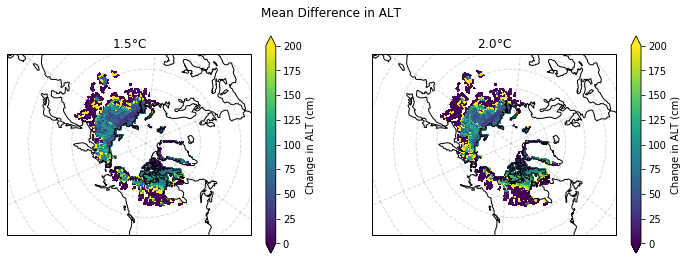

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), subplot_kw=dict(projection=Rasm()))

plt.sca(axes[0])
(alt_1pt5_diff_mean * 100).where((domain.mask==1) & (alt_1pt5_diff_mean != 0)).plot.pcolormesh('xc', 'yc', add_labels=False, 
                        cbar_kwargs={'label': 'Change in ALT (cm)'}, 
                       cmap='viridis', vmin=0, vmax=200, transform=ccrs.PlateCarree())
axes[0].set_title('$1.5\degree$C')
axes[0].gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='gray', alpha=0.3, linestyle='--')
axes[0].coastlines()

plt.sca(axes[1])
(alt_2pt0_diff_mean * 100).where((domain.mask==1) & (alt_2pt0_diff_mean != 0)).plot.pcolormesh('xc', 'yc', add_labels=False, 
                        cbar_kwargs={'label': 'Change in ALT (cm)'}, 
                       cmap='viridis', vmin=0, vmax=200, transform=ccrs.PlateCarree())
axes[1].set_title('$2.0\degree$C')
axes[1].gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='gray', alpha=0.3, linestyle='--')
axes[1].coastlines()
plt.suptitle('Mean Difference in ALT')

'''fig.savefig(os.path.join(plot_direc, 
                         'alt_diff_mean.png'), bbox_inches='tight', dpi=dpi)'''

"fig.savefig(os.path.join(plot_direc, \n                         'alt_diff_max.png'), bbox_inches='tight', dpi=dpi)"

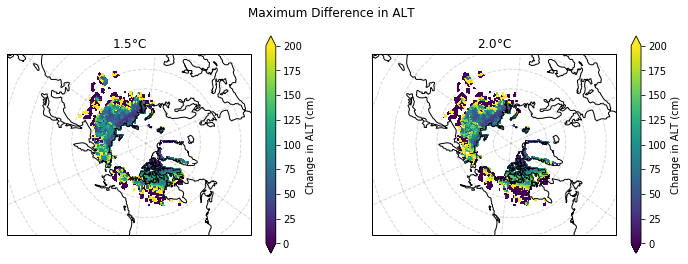

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), subplot_kw=dict(projection=Rasm()))

plt.sca(axes[0])
(alt_1pt5_diff_max * 100).where((domain.mask==1) & (alt_1pt5_diff_max != 0)).plot.pcolormesh('xc', 'yc', add_labels=False, 
                        cbar_kwargs={'label': 'Change in ALT (cm)'}, 
                       cmap='viridis', vmin=0, vmax=200, transform=ccrs.PlateCarree())
axes[0].set_title('$1.5\degree$C')
axes[0].gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='gray', alpha=0.3, linestyle='--')
axes[0].coastlines()

plt.sca(axes[1])
(alt_2pt0_diff_max * 100).where((domain.mask==1) & (alt_2pt0_diff_max != 0)).plot.pcolormesh('xc', 'yc', add_labels=False, 
                        cbar_kwargs={'label': 'Change in ALT (cm)'}, 
                       cmap='viridis', vmin=0, vmax=200, transform=ccrs.PlateCarree())
axes[1].set_title('$2.0\degree$C')
axes[1].gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='gray', alpha=0.3, linestyle='--')
axes[1].coastlines()
plt.suptitle('Maximum Difference in ALT')

'''fig.savefig(os.path.join(plot_direc, 
                         'alt_diff_max.png'), bbox_inches='tight', dpi=dpi)'''

"fig.savefig(os.path.join(plot_direc, \n                         'alt_diff_ens_range.png'), bbox_inches='tight', dpi=dpi)"

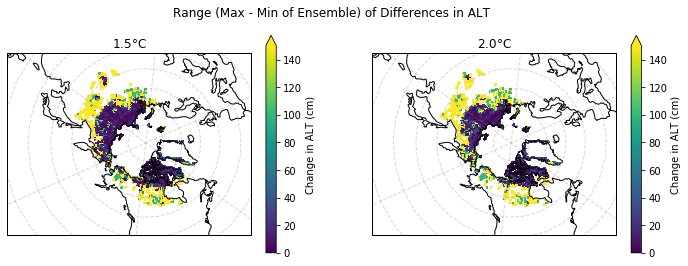

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), subplot_kw=dict(projection=Rasm()))

plt.sca(axes[0])
(alt_1pt5_range * 100).where((domain.mask==1) & (alt_1pt5_range != 0)).plot.pcolormesh('xc', 'yc', add_labels=False, 
                        cbar_kwargs={'label': 'Change in ALT (cm)'}, 
                       cmap='viridis', vmin=0, vmax=150, transform=ccrs.PlateCarree())
axes[0].set_title('$1.5\degree$C')
axes[0].gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='gray', alpha=0.3, linestyle='--')
axes[0].coastlines()

plt.sca(axes[1])
(alt_2pt0_range * 100).where((domain.mask==1) & (alt_2pt0_range != 0)).plot.pcolormesh('xc', 'yc', add_labels=False, 
                        cbar_kwargs={'label': 'Change in ALT (cm)'}, 
                       cmap='viridis', vmin=0, vmax=150, transform=ccrs.PlateCarree())
axes[1].set_title('$2.0\degree$C')
axes[1].gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='gray', alpha=0.3, linestyle='--')
axes[1].coastlines()
plt.suptitle('Range (Max - Min of Ensemble) of Differences in ALT')

'''fig.savefig(os.path.join(plot_direc, 
                         'alt_diff_ens_range.png'), bbox_inches='tight', dpi=dpi)'''

__calculate ALT sensitivities by hydroclimate class__

In [34]:
grid = 'wr50a_ar9v4'
classes = xr.open_dataset(os.path.join('/p/work1/gergel/lwe',
                                             'hydroclimate_masks_%s.nc' %grid))

In [37]:
# plotting specs

colors = dict(zip(['polar', 'cold_dry_perma', 'cold_wds_cs_perma'], 
                  
                  ["#95a5a6", "#2ecc71", "#e81a4a"]))

sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.2,)
plt.rcParams.update({'mathtext.default':  'regular' })

In [39]:
tbot_diff_1pt5 = tbot_1pt5.mean('time') - tbot_hist.mean('time')
tbot_diff_2pt0 = tbot_2pt0.mean('time') - tbot_hist.mean('time')

In [40]:
tbot_diff_1pt5_mean = tbot_diff_1pt5.mean('ensemble_member')
tbot_diff_2pt0_mean = tbot_diff_2pt0.mean('ensemble_member')

tbot_diff_1pt5_max = tbot_diff_1pt5.max('ensemble_member')
tbot_diff_2pt0_max = tbot_diff_2pt0.max('ensemble_member')

__Plot ALT Sensitivities by Hydroclimate Class__

/p/home/gergel/miniconda3/envs/pangeo_onyx/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/p/home/gergel/miniconda3/envs/pangeo_onyx/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


finished plotting 1pt5 for polar, sens value is 117.304004


/p/home/gergel/miniconda3/envs/pangeo_onyx/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/p/home/gergel/miniconda3/envs/pangeo_onyx/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


finished plotting 1pt5 for cold_dry_perma, sens value is -5.853183


/p/home/gergel/miniconda3/envs/pangeo_onyx/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/p/home/gergel/miniconda3/envs/pangeo_onyx/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


finished plotting 1pt5 for cold_wds_cs_perma, sens value is 43.887832


/p/home/gergel/miniconda3/envs/pangeo_onyx/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/p/home/gergel/miniconda3/envs/pangeo_onyx/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


finished plotting 2pt0 for polar, sens value is 80.549983


/p/home/gergel/miniconda3/envs/pangeo_onyx/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/p/home/gergel/miniconda3/envs/pangeo_onyx/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


finished plotting 2pt0 for cold_dry_perma, sens value is -21.087866


/p/home/gergel/miniconda3/envs/pangeo_onyx/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/p/home/gergel/miniconda3/envs/pangeo_onyx/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


finished plotting 2pt0 for cold_wds_cs_perma, sens value is 10.466117


"fig.savefig(os.path.join(plot_direc, \n                         'alt_sensitivity_ens_mean_hydroclimate_classes.png'), \n            bbox_inches='tight', \n            dpi=dpi)"

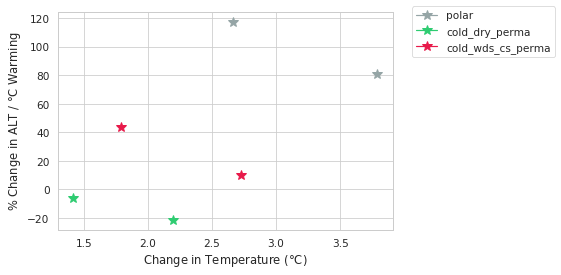

In [45]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

temp_scenarios_annual_means = {}
temp_scenarios_annual_means['1pt5'] = alt_1pt5_mean['TSOI']
temp_scenarios_annual_means['2pt0'] = alt_2pt0_mean['TSOI']

tbot_scenarios_annual_means = {}
tbot_scenarios_annual_means['1pt5'] = tbot_diff_1pt5_mean
tbot_scenarios_annual_means['2pt0'] = tbot_diff_2pt0_mean

x_values = [1.5, 2.0]
scenarios = ['1pt5', '2pt0']
# scenarios = ['1pt5']
# hydroclimate_classes = ['polar']
hydroclimate_classes = ['polar', 'cold_dry_perma', 'cold_wds_cs_perma']

for i, scenario in enumerate(scenarios):
    for hydroclimate_class in hydroclimate_classes:
        scen_ann_mean = temp_scenarios_annual_means[scenario]
        tbot_ann_mean = tbot_scenarios_annual_means[scenario]
        alt_scen_hc = np.asscalar(scen_ann_mean.where(classes[hydroclimate_class] == 1, 
                                                         drop=True).mean(dim=('nj', 'ni')).values)
        '''alt_scen_hist = np.asscalar(alt_hist_mean['TSOI'].where(classes[hydroclimate_class] == 1, 
                                                                     drop=True).mean(dim=('nj', 'ni')).values)'''
        alt_scen_hist = np.asscalar(alt_hist_mean.where(classes[hydroclimate_class] == 1, 
                                                                     drop=True).mean(dim=('nj', 'ni')).values)
        x_val = np.asscalar(tbot_ann_mean.where(classes[hydroclimate_class] == 1, 
                                                         drop=True).mean(dim=('nj', 'ni')).values)
        y_val = ((((alt_scen_hc - alt_scen_hist) / alt_scen_hist) * 100) / x_val)
        axes.plot(x_val, y_val, marker='*', color=colors[hydroclimate_class], 
                  label=hydroclimate_class, markersize=10)
        if i == 0: 
            axes.legend(bbox_to_anchor=(1.5, 1.05))
        print('finished plotting %s for %s, sens value is %f' %(scenario, hydroclimate_class, y_val))
plt.xlabel('Change in Temperature ($\degree$C)')
plt.ylabel('% Change in ALT / $\degree$C Warming')
# plt.ylim([0, 10])
'''fig.savefig(os.path.join(plot_direc, 
                         'alt_sensitivity_ens_mean_hydroclimate_classes.png'), 
            bbox_inches='tight', 
            dpi=dpi)'''